In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential,load_model
from keras import layers,Input
from keras.losses import binary_crossentropy
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
import keras.backend as K

2023-12-10 11:22:22.583517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 11:22:25.215023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Old data

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-12-04 14:08:29.338374: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
state0=np.load('../Data/new/2gsps/state0.npy')
state1=np.load('../Data/new/2gsps/state1.npy')
output0=np.zeros((state0.shape[0]))
output1=np.ones((state1.shape[0]))
print(state1.shape)

(20000,)


In [5]:
x=np.vstack((state0,state1))
print(x.shape)
y=np.hstack((output0,output1))
print(y.shape)

(40000, 2)
(40000,)


(40000, 2)
(40000,)
[1.01906041]
[0.50951747]
[0.50951747]
X shape: (40000, 1)


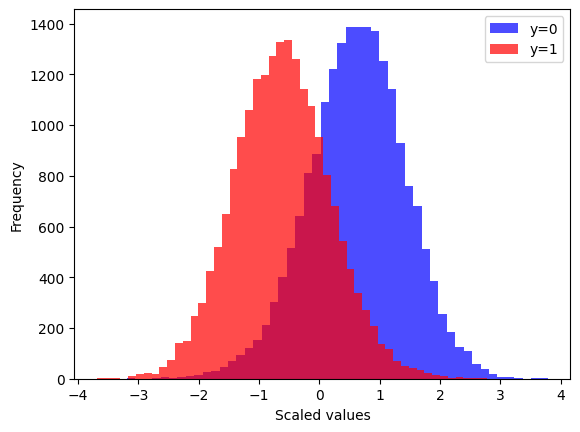

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x=np.vstack((state0,state1))
print(x.shape)
y=np.hstack((output0,output1))
print(y.shape)
sc = StandardScaler()
sc = StandardScaler()
x=x[:,700:2700,:].sum(axis=1)
X= sc.fit_transform(x)
# X_test = sc.transform(x_test)
pca = PCA(n_components = 1)
X = pca.fit_transform(X)
print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())
# X_test = pca.transform(X_test)
print("X shape: {}".format(X.shape))
x_red =X[y[:] == 1, 0]  # Use y[:, 0] for indexing
x_blue = X[y[:] == 0, 0] 

# Create a histogram with two different colors
plt.hist(x_blue, bins=50, color='blue', alpha=0.7, label='y=0')
plt.hist(x_red, bins=50, color='red', alpha=0.7, label='y=1')
# Add labels and legend
plt.xlabel('Scaled values')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

In [38]:

st,ed=700,7700
x_train, x_test, y_train, y_test = train_test_split(x[:,st:ed,:], y, test_size=0.30, random_state=45)
print(x_train.shape)
print(y_train.sum())

x_train=np.mean(x_train,axis=1)
x_test=np.mean(x_test,axis=1)

# x_train=x_train.reshape((x_train.shape[0],x_train.shape[1]*2))
# x_test=x_test.reshape((x_test.shape[0],x_test.shape[1]*2))
print(x_train.shape)

(8400, 7000, 2)
4233.0
(8400, 2)


## Logistic Regression

In [39]:
# x_trainC=x_train.reshape((x_train.shape[0],x_train.shape[1]*2))
# x_testC=x_test.reshape((x_test.shape[0],x_test.shape[1]*2))
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x_train, y_train)
print(classifier.score(x_test,y_test))
pred = classifier.predict(x_test)

0.9633333333333334


## SVM

In [6]:
model=SVC(decision_function_shape='ovo')
model.fit(x_train,y_train)
print(model.score(x_test,y_test))
pred=model.predict(x_test)

0.8155


## GMM

In [ ]:
Y=list(zip(np.append(np.mean(state0[:,st:ed,0],axis=1),np.mean(state1[:,st:ed,0],axis=1)),np.append(np.mean(state0[:,st:ed,1],axis=1),np.mean(state1[:,st:ed,1],axis=1))))
gmm_Y=GaussianMixture(n_components=2,covariance_type='full').fit(Y)
bitstring=np.split(gmm_Y.predict(Y),2)
print('P(0|0)=',len(bitstring[0][bitstring[0]==0])/len(bitstring[0]))
print('P(1|1)=',len(bitstring[1][bitstring[1]==1])/len(bitstring[1]))
X=list(zip(np.mean(state0[:,st:ed,0],axis=1),np.mean(state0[:,st:ed,1],axis=1)))
gmm_Y_1=GaussianMixture(n_components=1,covariance_type='spherical').fit(X)
X=list(zip(np.mean(state1[:,st:ed,0],axis=1),np.mean(state1[:,st:ed,1],axis=1)))
gmm_Y_2=GaussianMixture(n_components=1,covariance_type='spherical').fit(X)

## NN

In [5]:
def arch():
    model=Sequential()
    model.add(Input(shape=(2), name='Input Layer'))
    model.add(Dense(8,activation='relu', name='HiddenLayer1'))
    model.add(Dense(4,activation='relu', name='HiddenLayer2'))
    model.add(Dense(1,activation='sigmoid', name='OuputLayer'))
    return model
arch().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 8)                 24        
                                                                 
 HiddenLayer2 (Dense)        (None, 4)                 36        
                                                                 
 OuputLayer (Dense)          (None, 1)                 5         
                                                                 
Total params: 65 (260.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-11-20 12:11:58.790584: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
def bceloss(y_true, y_pred):
    # Clip the prediction value to prevent log(0) error
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Calculate the weighted binary cross entropy loss
    loss = -(0.1 * (y_true * K.log(y_pred)) + 0.9*((1 - y_true) * K.log(1 - y_pred)))
    return K.mean(loss, axis=-1)

model=arch()
model.summary
opt=SGD( learning_rate=0.01, momentum=0.9)
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model_path="../Model/NN2/tmp/{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [7]:
H=model.fit(x_train,y_train,
          validation_split=0.2,
          epochs=100,batch_size=64,
        #   callbacks=callbacks_list,
          verbose=1)

Epoch 1/100
105/105 [==============================] - 1s 3ms/step - loss: 0.5656 - accuracy: 0.8287 - val_loss: 0.4754 - val_accuracy: 0.8923
Epoch 2/100
105/105 [==============================] - 0s 2ms/step - loss: 0.3904 - accuracy: 0.9103 - val_loss: 0.2787 - val_accuracy: 0.9339
Epoch 3/100
105/105 [==============================] - 0s 1ms/step - loss: 0.2329 - accuracy: 0.9415 - val_loss: 0.1941 - val_accuracy: 0.9452
Epoch 4/100
105/105 [==============================] - 0s 1ms/step - loss: 0.1875 - accuracy: 0.9469 - val_loss: 0.1724 - val_accuracy: 0.9482
Epoch 5/100
105/105 [==============================] - 0s 1ms/step - loss: 0.1727 - accuracy: 0.9507 - val_loss: 0.1632 - val_accuracy: 0.9554
Epoch 6/100
105/105 [==============================] - 0s 1ms/step - loss: 0.1652 - accuracy: 0.9555 - val_loss: 0.1580 - val_accuracy: 0.9571
Epoch 7/100
105/105 [==============================] - 0s 1ms/step - loss: 0.1606 - accuracy: 0.9589 - val_loss: 0.1546 - val_accuracy: 0.9595

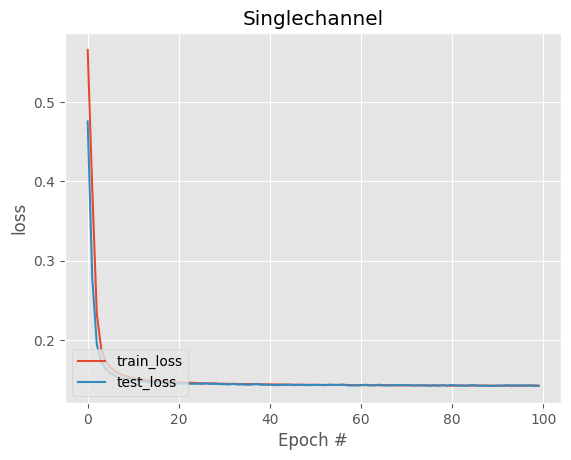

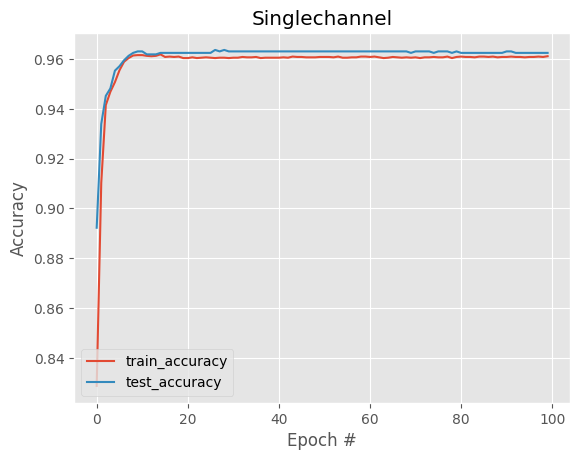

In [8]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Singlechannel")
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend(loc="lower left")

N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_accuracy")
plt.title("Singlechannel")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [ ]:
model=load_model('../Model/NN2/tmp/29-0.7716.h5', compile=False)
count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==1:
        count+=1
        if y_pred[i]>=0.5:
            count1+=1
print(count,count1)

In [ ]:
np.save('../x_text.npy',x_test)
np.save('../y_test.npy',y_test)

## GDA

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianDiscriminantAnalysis:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = np.array([np.mean(y == c) for c in self.classes])

        self.means = []
        self.cov_matrices = []
        for c in self.classes:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            cov_matrix_c = np.cov(X_c, rowvar=False)
            self.means.append(mean_c)
            self.cov_matrices.append(cov_matrix_c)

    def predict(self, X):
        posteriors = []

        for c in self.classes:
            class_prior = self.class_priors[int(c)]
            mean = self.means[int(c)]
            cov_matrix = self.cov_matrices[int(c)]
            mvn = multivariate_normal(mean=mean, cov=cov_matrix)
            posterior = class_prior * mvn.pdf(X)
            posteriors.append(posterior)

        posteriors = np.array(posteriors).T
        predicted_labels = np.argmax(posteriors, axis=1)

        return predicted_labels



# Initialize and train GDA
gda = GaussianDiscriminantAnalysis()
gda.fit(x_train, y_train)

# Make predictions
y_pred = gda.predict(x_train)
# Calculate accuracy
accuracy = np.mean(y_pred == y_train)
print(f"Accuracy: {accuracy * 100:.2f}%")

## MultiChannel

In [2]:
import numpy as np
import pandas as pd
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
# def plotCluster(s0I,s0Q,s1I,s1Q,e0I,e0Q,e1I,e1Q,f0I,f0Q,f1I,f1Q,):
#     fig = make_subplots(rows=1, cols=1)
#     trace0 = go.Scatter(x=s0I, y=s0Q, name='0-500_|0>',mode='markers',line=dict(color='blue'),marker=dict(size=8, symbol='circle-open'))
#     trace1 = go.Scatter(x=s1I, y=s1Q, name='0-500_|1>',mode='markers',line=dict(color='red'),marker=dict(size=8,symbol='square-open'))
#     trace2 = go.Scatter(x=e0I, y=e0Q, name='500-1000_|0>',mode='markers',line=dict(color='black'),marker=dict(size=8,symbol='star-open'))
#     trace3 = go.Scatter(x=e1I, y=e1Q, name='500-1000_|1>',mode='markers',line=dict(color='green'),marker=dict(size=8, symbol='diamond-open'))
#     trace4 = go.Scatter(x=f0I, y=f0Q, name='1000-1500_|0>',mode='markers',line=dict(color='orange'),marker=dict(size=8,symbol='square-cross-open'))
#     trace5 = go.Scatter(x=f1I, y=f1Q, name='1000-1500_|1>',mode='markers',line=dict(color='pink'),marker=dict(size=8, symbol='diamond-cross-open'))
#     fig.add_trace(trace0)
#     fig.add_trace(trace1)
#     fig.add_trace(trace2)
#     fig.add_trace(trace3)
#     fig.add_trace(trace4)
#     fig.add_trace(trace5)
#     # Set the layout
#     fig.update_layout(
#         title="Signals 0-500-1000-1500",
#         xaxis_title="I",
#         yaxis_title="Q",
#         showlegend=True,
#         width=800,  # Set the width of the plot
#         height=400,  # Set the height of the plot
#     )
#     return fig  

def plotCluster(s0I,s0Q,s1I,s1Q, name1, name2):
    fig = make_subplots(rows=1, cols=1)
    trace0 = go.Scatter(x=s0I, y=s0Q, name=name1,mode='markers',line=dict(color='blue'),marker=dict(size=8, symbol='circle-open'))
    trace1 = go.Scatter(x=s1I, y=s1Q, name=name2,mode='markers',line=dict(color='red'),marker=dict(size=8,symbol='square-open'))
    fig.add_trace(trace0)
    fig.add_trace(trace1)
    # Set the layout
    fig.update_layout(
        title="Signals",
        xaxis_title="I",
        yaxis_title="Q",
        showlegend=True,
        width=800,  # Set the width of the plot
        height=400,  # Set the height of the plot
    )
    return fig  

In [6]:
# state0_500= np.mean(state0[:,700:1700,:],axis=1)
# state1_500= np.mean(state1[:,700:1700,:],axis=1)
# state0_1000= np.mean(state0[:,1700:2700,:],axis=1)
# state1_1000= np.mean(state1[:,1700:2700,:],axis=1)
# state0_1500= np.mean(state0[:,2700:3700,:],axis=1)
# state1_1500= np.mean(state1[:,2700:3700,:],axis=1)
# state0_4=np.hstack((state0_500,state0_1000,state0_1500))
# state1_4=np.hstack((state1_500,state1_1000,state1_1500))

# indices = np.arange(6000)
# np.random.shuffle(indices)
# selected_indices = indices[:1000]
# random0 = state0_4[selected_indices]
# random1 = state1_4[selected_indices]


# print(random0.shape)

(1000, 6)


In [6]:
state0_100= np.sum(state0[:,1500:1700,:],axis=1)
state1_100= np.sum(state1[:,1500:1700,:],axis=1)
state0_200= np.sum(state0[:,1900:2100,:],axis=1)
state1_200= np.sum(state1[:,1900:2100,:],axis=1)
state0_300= np.sum(state0[:,2100:2300,:],axis=1)
state1_300= np.sum(state1[:,2100:2300,:],axis=1)
state0_400= np.sum(state0[:,2300:2500,:],axis=1)
state1_400= np.sum(state1[:,2300:2500,:],axis=1)
state0_500= np.sum(state0[:,2500:2700,:],axis=1)
state1_500= np.sum(state1[:,2500:2700,:],axis=1)
state0_4=np.hstack((state0_100,state0_200,state0_300,state0_400,state0_500))
state1_4=np.hstack((state1_100,state1_200,state1_300,state1_400,state1_500))

indices = np.arange(6000)
np.random.shuffle(indices)
selected_indices = indices[:1000]
random0 = state0_4[selected_indices]
random1 = state1_4[selected_indices]


print(random0.shape)

(1000, 10)


In [7]:
# plotCluster(random0[:,0], random0[:,1], random1[:,0], random1[:,1], random0[:, 2], random0[:, 3], random1[:,2], random1[:,3],random0[:, 4], random0[:, 5], random1[:,4], random1[:,5])
plotCluster(random0[:,0], random0[:,1], random1[:,0], random1[:,1],'500-600_|0>', '500-600_|1>').show()
plotCluster(random0[:, 2], random0[:, 3], random1[:,2], random1[:,3],'600-700_|0>', '600-700_|1>').show()
plotCluster(random0[:, 4], random0[:, 5], random1[:,4], random1[:,5],'700-800_|0>', '700-800_|1>').show()
plotCluster(random0[:,6], random0[:,7], random1[:,6], random1[:,7],'800-900_|0>', '800-900_|1>').show()
plotCluster(random0[:, 8], random0[:, 9], random1[:,8], random1[:,9],'900-1000_|0>', '900-1000_|1>').show()
# plotCluster(np.sum(state0[selected_indices,1700:3700, 0],axis=1), np.sum(state0[selected_indices,1700:3700, 1],axis=1), np.sum(state1[selected_indices,1700:3700,0],axis=1), np.sum(state1[selected_indices,1700:3700,1],axis=1),'900-1000_|0>', '900-1000_|1>').show()


In [48]:
x=np.vstack((state0_4,state1_4))
print(x.shape)
y=np.hstack((output0,output1))
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=45)
print(x_train.shape)
print(y_train.sum())

(12000, 10)
(12000,)
(8400, 10)
4233.0


In [49]:
def arch():
    model=Sequential()
    model.add(Input(shape=(10), name='Input Layer'))
    model.add(Dense(16,activation='relu', name='HiddenLayer1'))
    model.add(Dense(4,activation='relu', name='HiddenLayer2'))
    model.add(Dense(1,activation='sigmoid', name='OuputLayer'))
    return model
arch().summary()

model=arch()
model.summary
opt=SGD( learning_rate=0.01, momentum=0.9)
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model_path="../Model/NN2/tmp/{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

H=model.fit(x_train,y_train,
          validation_split=0.2,
          epochs=100,batch_size=64,
        #   callbacks=callbacks_list,
          verbose=1)
# model=load_model('../Model/NN2/tmp/29-0.7716.h5', compile=False)
count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==0:
        count+=1
        if y_pred[i]<=0.5:
            count1+=1
print(count,count1)

count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==1:
        count+=1
        if y_pred[i]>=0.5:
            count1+=1
print(count,count1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 HiddenLayer1 (Dense)        (None, 16)                176       
                                                                 
 HiddenLayer2 (Dense)        (None, 4)                 68        
                                                                 
 OuputLayer (Dense)          (None, 1)                 5         
                                                                 
Total params: 249 (996.00 Byte)
Trainable params: 249 (996.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
105/105 [==============================] - 1s 2ms/step - loss: 0.9397 - accuracy: 0.5542 - val_loss: 0.7290 - val_accuracy: 0.5714
Epoch 2/100
105/105 [==============================] - 0s 1ms/step - loss: 0.6768 - accuracy: 0.6030 - val_loss: 0.6556 - val_accuracy: 0.6012
Epoch 3/100
105/105 [==============================] - 0s 2ms/step - loss: 0.6375 - accuracy: 0.6354 - val_loss: 0.6253 - val_accuracy: 0.6488
Epoch

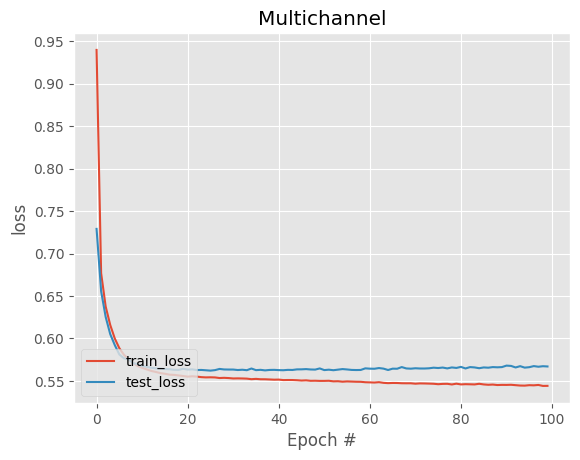

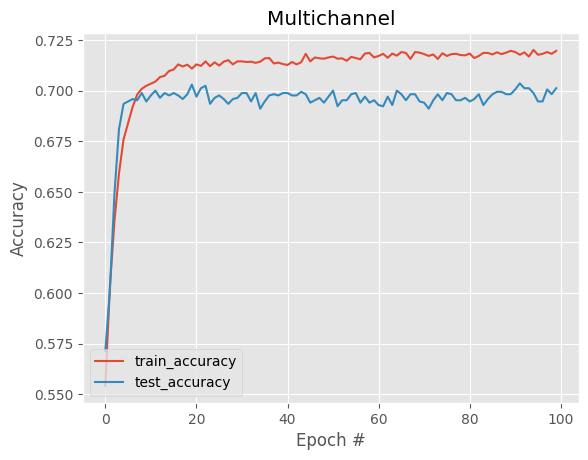

In [50]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Multichannel")
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend(loc="lower left")

N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_accuracy")
plt.title("Multichannel")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


Confusion Matrix:
[[1244  589]
 [ 470 1297]]


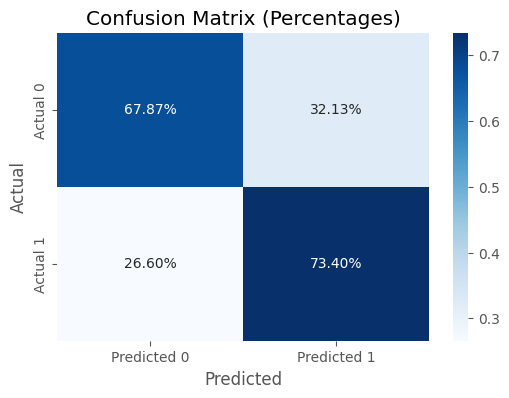

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


threshold = 0.5
y_pred = (y_pred > threshold).astype(int)
conf_mat = confusion_matrix(y_test, y_pred)

# Calculate percentages
conf_mat_percentage = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)

# Create a heatmap for better visualization with percentages
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Percentages)")
plt.show()

## New

In [36]:
state0=np.stack((np.load('../Data/neel_readout/120923/state0_15µs_cos.npy').real,np.load('../Data/neel_readout/120923/state0_15µs_cos.npy').imag),axis=1)
state1=np.stack((np.load('../Data/neel_readout/120923/state1_15µs_cos.npy').real,np.load('../Data/neel_readout/120923/state1_15µs_cos.npy').imag),axis=1)
output0=np.zeros((state0.shape[0]))
output1=np.ones((state1.shape[0]))
print(state0.shape)

(20000, 2)


In [37]:
x=np.vstack((state0,state1))
print(x.shape)
y=np.hstack((output0,output1))
print(y.shape)

min,max= -(2**20),(2**20)
print('Min: %.3f, Max: %.3f' % (x.min(), x.max()))
x= (x-min)/(max-min)
print('Min: %.3f, Max: %.3f' % (x.min(), x.max()))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.80, random_state=45)
print(x_train.shape)
print(y_train.sum())

(40000, 2)
(40000,)
Min: -215013.000, Max: 256939.000
Min: 0.397, Max: 0.623
(8000, 2)
4080.0


[1.01449737]
[0.507236]
[0.507236]
X shape: (40000, 1)


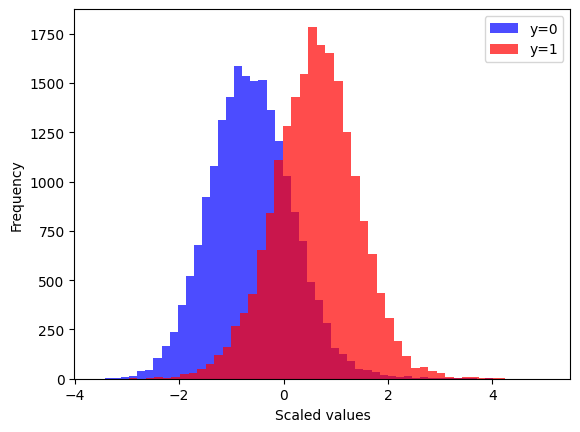

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X= sc.fit_transform(x)
pca = PCA(n_components = 1)
X = pca.fit_transform(X)
print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())
# X_test = pca.transform(X_test)
print("X shape: {}".format(X.shape))
x_red =X[y[:] == 1, 0]  # Use y[:, 0] for indexing
x_blue = X[y[:] == 0, 0] 

# Create a histogram with two different colors
plt.hist(x_blue, bins=50, color='blue', alpha=0.7, label='y=0')
plt.hist(x_red, bins=50, color='red', alpha=0.7, label='y=1')
# Add labels and legend
plt.xlabel('Scaled values')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

In [30]:
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x_train, y_train)
print(classifier.score(x_test,y_test))
pred = classifier.predict(x_test)

0.95571875


In [31]:
model=SVC(decision_function_shape='ovo')
model.fit(x_train,y_train)
print(model.score(x_test,y_test))
pred=model.predict(x_test)

0.95525


In [32]:
def arch():
    model=Sequential()
    model.add(Input(shape=(2), name='Input Layer'))
    model.add(Dense(8,activation='relu', name='HiddenLayer1'))
    model.add(Dense(4,activation='relu', name='HiddenLayer2'))
    model.add(Dense(1,activation='sigmoid', name='OuputLayer'))
    return model
arch().summary()

model=arch()
model.summary
opt=SGD( learning_rate=0.01, momentum=0.9)
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model_path="../Model/NN2/tmp/{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

H=model.fit(x_train,y_train,
          validation_split=0.2,
          epochs=100,batch_size=64,
        #   callbacks=callbacks_list,
          verbose=1)
# model=load_model('../Model/NN2/tmp/29-0.7716.h5', compile=False)
count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==0:
        count+=1
        if y_pred[i]<=0.5:
            count1+=1
print(count,count1)

count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==1:
        count+=1
        if y_pred[i]>=0.5:
            count1+=1
print(count,count1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 8)                 24        
                                                                 
 HiddenLayer2 (Dense)        (None, 4)                 36        
                                                                 
 OuputLayer (Dense)          (None, 1)                 5         
                                                                 
Total params: 65 (260.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 0.7339 - accuracy: 0.5045 - val_loss: 0.6983 - val_accuracy: 0.5319
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.5041 - val_loss: 0.6928 - val_accuracy: 0.5294
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5277 - val_loss: 0.6882 - val_accuracy: 0.6631
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 0.6889 - val_loss: 0.6817 - val_accuracy: 0.8200
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6784 - accuracy: 0.7887 - val_loss: 0.6737 - val_accuracy: 0.8881
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6695 - accuracy: 0.8222 - val_loss: 0.6629 - val_accuracy: 0.9062
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6575 - accuracy: 0.8578 - val_loss: 0.6473 - val_accuracy: 0.7881